# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1106523, 883932, 871756, 1044078]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 999270, 1078652, 15778319]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[1012801, 820612, 918638, 874563, 5574377]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(5)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


In [10]:
data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()

,user_id,item_id
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."
...,...,...
2149,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16..."
2150,2497,"[820291, 824759, 838797, 859010, 859075, 86077..."
2151,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15..."
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86..."


In [11]:
K = 50

new_users = np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()
result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(new_users)]

result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda X: recommender.get_own_recommendations(X, N=K))
result_lvl_1.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], K), axis=1).mean()

0.06525657038145175

In [12]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda X: recommender.get_als_recommendations(X, N=K))
result_lvl_1.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], K), axis=1).mean()

0.04704445401476547

In [13]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda X: recommender.get_similar_items_recommendation(X, N=K))
result_lvl_1.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], K), axis=1).mean()

0.03337864244119207

Вывод: Own recommendations + top popular дали наилучший результат.

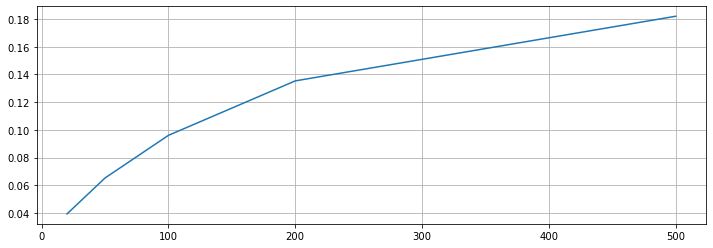

In [14]:
n = [20, 50, 100, 200, 500]
rec_list = []

for i in n:
    result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda X: recommender.get_own_recommendations(X, N=i))
    rec_list.append(result_lvl_1.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], i), axis=1).mean())
    
plt.figure(figsize=(12, 4))
plt.plot(n, rec_list)
plt.grid(True)   

Вывод : recall@k растет при увеличении k
По моеему мнению примерно k=100 наиболее разумно.
Но надо действовать, исходя из задачи, и количества товаров, которые нужно порекомендовать пользователю.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

#### Добавляем фичей продуктам

In [15]:
new_item_features = item_features.merge(data, on='item_id', how='left')
new_item_features.head(5)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,user_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1228.0,2.904662e+10,157.0,1.0,3.49,3313.0,0.0,2213.0,23.0,0.0,0.0
1,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,358.0,3.070761e+10,247.0,1.0,3.49,3266.0,0.0,1211.0,36.0,0.0,0.0
2,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,325.0,3.304671e+10,410.0,4.0,13.96,3191.0,0.0,1139.0,59.0,0.0,0.0
3,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1675.0,3.076027e+10,250.0,1.0,0.99,3235.0,0.0,936.0,36.0,0.0,0.0
4,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1032.0,3.378385e+10,458.0,1.0,1.59,33904.0,0.0,2034.0,66.0,0.0,0.0


In [16]:
# Продажи продуктов/неделя
item_quantity = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
item_quantity.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
item_quantity['weekly_quantity_of_sales'] = item_quantity['quantity_of_sales'] / new_item_features['week_no'].nunique()
item_quantity.head(5)

,item_id,quantity_of_sales,weekly_quantity_of_sales
0,25671,3,0.031579
1,26081,1,0.010526
2,26093,1,0.010526
3,26190,1,0.010526
4,26355,1,0.010526


In [17]:
# Средняя цена продуктов
price = new_item_features.groupby('item_id')['sales_value'].sum() / new_item_features.groupby('item_id')['quantity'].sum()
price = price.groupby('item_id').mean().reset_index()
price.columns = ['item_id', 'price']
price['price'].fillna(0, inplace= True)
price.head(5)

,item_id,price
0,25671,3.49
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,0.99


In [18]:
# Примерджим все среднюю цену и количество продуктов к фичам продуктов
item_features = item_features.merge(item_quantity, on='item_id')
item_features = item_features.merge(price, on='item_id')
item_features = item_features[item_features['weekly_quantity_of_sales'] > 0]
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity_of_sales,weekly_quantity_of_sales,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,3,0.031579,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1,0.010526,0.99
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1,0.010526,1.59
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1,0.010526,1.54
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,1,0.010526,0.99


#### Добавляем фичей пользователям

In [19]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [20]:
# Женим фичи пользователю
new_user_features = user_features.merge(data, on='user_id', how='left')
new_user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,825123,1,3.99,436,0.00,1456,8,0.0,0.0
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,831447,1,2.99,436,0.00,1456,8,0.0,0.0
2,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,840361,1,1.09,436,-0.30,1456,8,0.0,0.0
3,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,845307,1,3.71,436,-0.62,1456,8,0.0,0.0
4,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,852014,1,2.79,436,-1.20,1456,8,0.0,0.0


In [21]:
def resolve_income_desc(x):
    if x is None:
        return 10
    regexpResult = re.match(r'\d+', x)
    return regexpResult.group(0) if regexpResult is not None else 10

new_user_features['income_desc'] = new_user_features['income_desc'].fillna('0')
new_user_features['income_desc'] = new_user_features['income_desc'].apply(resolve_income_desc)
new_user_features['income_desc'].head()

0    35
1    35
2    35
3    35
4    35
Name: income_desc, dtype: object

In [22]:
# Мерджим среднюю корзину
basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()
basket_quantity = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
basket_quantity.rename(columns={'basket_id': 'basket_quantity'}, inplace=True)
average_basket = basket.merge(basket_quantity)
average_basket['average_basket'] = average_basket.sales_value / average_basket.basket_quantity
average_basket['weekly_sum'] = average_basket.sales_value / new_user_features.week_no.nunique()
average_basket = average_basket.drop(['sales_value', 'basket_quantity'], axis=1)

user_features = user_features.merge(average_basket)

In [23]:
def preprocessing(data, data_level_1):
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']
    train_users = data_level_1['user_id'].unique()
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    users_lvl_2_ = users_lvl_2.copy()
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['flag'] = 1
    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2.head(2)
    targets_lvl_2['target'] = 1  
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
    X = targets_lvl_2.drop('target', axis=1)
    y = targets_lvl_2[['target']]
    
    return X, y

In [24]:
X_train, y_train = preprocessing(data_train_lvl_2, data_train_lvl_1)
X_test, y_test = preprocessing(data_val_lvl_2, data_train_lvl_1)

In [25]:
categorial_features = X_train.columns[2:].tolist()
categorial_features

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'quantity_of_sales',
 'weekly_quantity_of_sales',
 'price',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_basket',
 'weekly_sum']

In [26]:
X_train[categorial_features] = X_train[categorial_features].astype('category')
X_test[categorial_features] = X_test[categorial_features].astype('category')

In [27]:
lgb = LGBMClassifier(objective='binary', max_depth=10, categorical_column=categorial_features)
lgb.fit(X_train, y_train)

test_preds_proba = lgb.predict_proba(X_test)[:, 1]

/Users/AShipkov/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/AShipkov/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [28]:
test_preds_proba[:10]

array([0.28584561, 0.28584561, 0.0353183 , 0.0353183 , 0.01344124,
       0.04698956, 0.0066831 , 0.00697864, 0.01062916, 0.34290773])

In [29]:
def get_recomendation(X_test, test_preds_proba, data_val_lvl_2):
    X_test['predict_proba'] = test_preds_proba
    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)
    result = X_test.groupby('user_id').head(5)
    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'recomendations': preds.tolist()})
    recomendations = pd.DataFrame(recomendations)
    result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_2.columns=['user_id', 'actual']
    result_lvl_2 = result_lvl_2.merge(recomendations)
    
    return result_lvl_2

In [30]:
result_lvl_2 = get_recomendation(X_test, test_preds_proba, data_val_lvl_2)

In [31]:
result_lvl_2.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.1454901960784298

#### Pаботает хуже одноуровневой модели

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 